In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-detection-fer


In [ ]:
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d ananthu017/emotion-detection-fer
  !unzip emotion-detection-fer.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Basic transform for grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Set directory paths
train_dir = 'train'
test_dir = 'test'

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False),
            nn.Sigmoid()
        )

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial Attention
        sa = self.spatial_attention(torch.cat([
            torch.max(x, dim=1, keepdim=True)[0],
            torch.mean(x, dim=1, keepdim=True)
        ], dim=1))
        x = x * sa

        return x


In [ ]:
  #      # === Custom kernels ===
   #     sobel_x = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)
    #    sobel_y = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
     #   center = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32)
      #  sharpen = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32)
       # diagonal = torch.tensor([[-1, 0, 1], [0, 0, 0], [1, 0, -1]], dtype=torch.float32)

       # kernels = torch.stack([sobel_x, sobel_y, center, sharpen, diagonal], dim=0).unsqueeze(1)
     #   self.custom_conv = nn.Conv2d(1, 5, kernel_size=3, padding=1, bias=False)
    #    self.custom_conv.weight = nn.Parameter(kernels, requires_grad=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomFERCNN_CBAM(nn.Module):
    def __init__(self):
        super().__init__()

          #      # === Custom kernels ===
        sobel_x = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        center = torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32)
        sharpen = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32)
        diagonal = torch.tensor([[-1, 0, 1], [0, 0, 0], [1, 0, -1]], dtype=torch.float32)

        kernels = torch.stack([sobel_x, sobel_y, center, sharpen, diagonal], dim=0).unsqueeze(1)
        self.custom_conv = nn.Conv2d(1, 5, kernel_size=3, padding=1, bias=False)
        self.custom_conv.weight = nn.Parameter(kernels, requires_grad=False)

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            CBAM(64),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            CBAM(128),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            CBAM(256),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomFERCNN_CBAM_Kernel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            CBAM(64),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            CBAM(128),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            CBAM(256),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x



In [ ]:
#Check for class imbalance issues
from collections import Counter
# Get the class labels and their corresponding indices
class_labels = train_dataset.classes

# Get the class distribution
class_counts = Counter([label for _, label in train_dataset.imgs])

# Print class distribution
for i, class_name in enumerate(class_labels):
    print(f"{class_name}: {class_counts[i]} samples")

# Total number of samples
total_samples = sum(class_counts.values())

# Calculate inverse frequencies (inverse of class counts)
inverse_frequencies = {class_id: total_samples / count for class_id, count in class_counts.items()}

# Normalize the inverse frequencies (so the largest weight is 1.0)
max_weight = max(inverse_frequencies.values())
normalized_weights = {class_id: weight / max_weight for class_id, weight in inverse_frequencies.items()}

# Convert the normalized weights to a tensor (PyTorch expects this format)
class_weights = torch.tensor([normalized_weights[i] for i in range(len(class_counts))])
class_weights = class_weights.to(device)

# Print the weights
print("Class weights:", class_weights)

angry: 3995 samples
disgusted: 436 samples
fearful: 4097 samples
happy: 7215 samples
neutral: 4965 samples
sad: 4830 samples
surprised: 3171 samples
Class weights: tensor([0.1091, 1.0000, 0.1064, 0.0604, 0.0878, 0.0903, 0.1375],
       device='cuda:0')


In [ ]:
import torch.optim as optim

model = CustomFERCNN_CBAM_Kernel().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler to decay LR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
import torchvision.transforms as transforms
'''
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
'''
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# Split the training dataset into train and validation sets
from torch.utils.data import random_split

batch_size = 64

val_percent = 0.3
num_train = int((1 - val_percent) * len(train_dataset))
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training step
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_loss_avg = val_running_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss_avg:.4f}, "
          f"Val Acc: {val_accuracy:.4f}")


Epoch [1/20] - Train Loss: 1.9140, Val Loss: 1.8174, Val Acc: 0.2780
Epoch [2/20] - Train Loss: 1.7778, Val Loss: 1.7113, Val Acc: 0.3390
Epoch [3/20] - Train Loss: 1.6606, Val Loss: 1.5396, Val Acc: 0.4123
Epoch [4/20] - Train Loss: 1.5285, Val Loss: 1.4518, Val Acc: 0.4341
Epoch [5/20] - Train Loss: 1.4344, Val Loss: 1.3903, Val Acc: 0.4533
Epoch [6/20] - Train Loss: 1.3773, Val Loss: 1.4293, Val Acc: 0.4706
Epoch [7/20] - Train Loss: 1.3071, Val Loss: 1.4175, Val Acc: 0.4842
Epoch [8/20] - Train Loss: 1.2390, Val Loss: 1.3466, Val Acc: 0.4635
Epoch [9/20] - Train Loss: 1.1975, Val Loss: 1.3207, Val Acc: 0.4970
Epoch [10/20] - Train Loss: 1.1286, Val Loss: 1.3106, Val Acc: 0.5348
Epoch [11/20] - Train Loss: 1.0704, Val Loss: 1.3170, Val Acc: 0.5313
Epoch [12/20] - Train Loss: 1.0402, Val Loss: 1.3362, Val Acc: 0.5377
Epoch [13/20] - Train Loss: 1.0042, Val Loss: 1.3337, Val Acc: 0.5478
Epoch [14/20] - Train Loss: 0.9469, Val Loss: 1.3952, Val Acc: 0.5626
Epoch [15/20] - Train Loss: 0

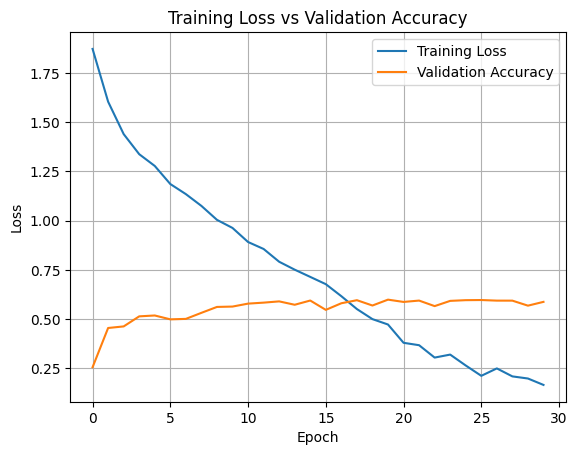

In [ ]:

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Validation Accuracy')
plt.grid(True)
plt.show()


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 59.00%


30 epochs with overfitting - 59.00%

20 epochs with overfitting - 59.99%

8 epochs avoid overfitting - 48.98%

################################

Test for GradCAM


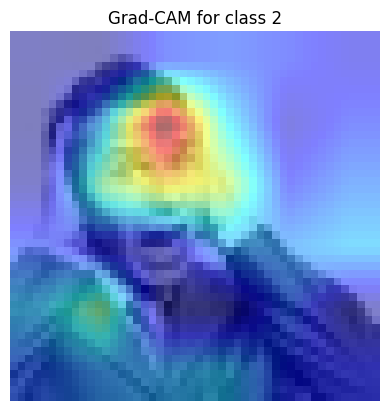

In [ ]:
# Install if needed
# !pip install grad-cam

import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

# === STEP 1: Select image ===
# Load and preprocess the image (48x48 grayscale to 3-channel RGB if needed)
img_path = 'train/fearful/im3.png'  # replace with your test image
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# Normalize the image to the range [0, 1]
image = image.astype(np.float32) / 255.0

transform = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0).to(device)  # shape: [1, 3, 48, 48]

# === STEP 2: Grad-CAM Setup ===
# Replace with your actual model layer (example below assumes CNN with named layers)
target_layer = model.conv_block3  # <-- change this to your last convolutional layer

cam = GradCAM(model=model, target_layers=[target_layer])

# === STEP 3: Generate CAM ===
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# === STEP 4: Visualization ===
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

visualization = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM for class {pred_class}")
plt.axis('off')
plt.show()


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

# Class names (change as needed for FER)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(class_names)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Accuracy per class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print results
for i, acc in enumerate(class_accuracies):
    print(f"{class_names[i]}: {acc*100:.2f}%")


Angry: 54.62%
Disgust: 46.46%
Fear: 39.80%
Happy: 78.24%
Sad: 62.32%
Surprise: 36.06%
Neutral: 74.78%


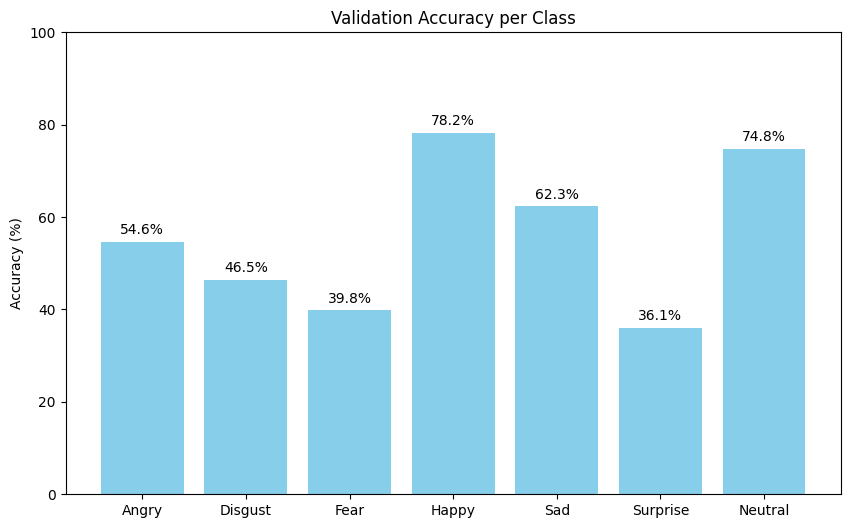

In [ ]:
# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_accuracies * 100, color='skyblue')
plt.ylim([0, 100])
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Class')

# Annotate bars
for bar, acc in zip(bars, class_accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{acc*100:.1f}%', ha='center', va='bottom')

plt.show()